<a href="https://colab.research.google.com/github/aryashinod/demo/blob/main/fisassignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
"""
Enhanced Confusion & Diffusion Metrics for Classical Ciphers
------------------------------------------------------------
- Diffusion = STE (symbol changes) + PCS (positional changes)
- Confusion = Key-Induced Ciphertext Entropy (KICE)
Adjustments:
  * Shift cipher punished for predictable cyclic shifts
  * Substitution downweighted for diffusion
  * Transposition PCS emphasized
"""

import math, random
from collections import Counter
from statistics import mean
import pandas as pd

# ----------------------------
# Utility
# ----------------------------
ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
MOD = 26
ADFGVX = "ADFGVX"
INP = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

def shannon_entropy(counts: Counter):
    total = sum(counts.values())
    if total == 0: return 0
    return -sum((v/total)*math.log2(v/total) for v in counts.values() if v > 0)

def normalize_entropy(entropy, alphabet_size):
    return entropy / math.log2(alphabet_size) if alphabet_size > 1 else 0

def random_plaintext(length, alphabet=ALPHABET):
    return ''.join(random.choice(alphabet) for _ in range(length))

# ----------------------------
# LCS helper
# ----------------------------
def lcs_length(a: str, b: str) -> int:
    la, lb = len(a), len(b)
    dp = [[0]*(lb+1) for _ in range(la+1)]
    for i in range(la-1, -1, -1):
        for j in range(lb-1, -1, -1):
            if a[i] == b[j]:
                dp[i][j] = 1 + dp[i+1][j+1]
            else:
                dp[i][j] = max(dp[i+1][j], dp[i][j+1])
    return dp[0][0]

# ----------------------------
# Diffusion Metric
# ----------------------------
def diffusion_metric(encrypt, key, alphabet, plaintext, trials=200, alpha=0.5):
    P_base = ''.join(ch for ch in plaintext.upper() if ch in alphabet)
    if len(P_base) < 5:
        P_base = random_plaintext(200, alphabet)

    N = len(alphabet)
    idx = {c: i for i, c in enumerate(alphabet)}
    delta_counts = Counter()
    pcs_list = []

    for _ in range(trials):
        pos = random.randrange(len(P_base))
        Pp = list(P_base)
        choices = [c for c in alphabet if c != P_base[pos]]
        Pp[pos] = random.choice(choices)
        Pp = ''.join(Pp)

        C = encrypt(P_base, key)
        Cp = encrypt(Pp, key)

        # STE
        for a, b in zip(C, Cp):
            if a in idx and b in idx:
                delta = (idx[b] - idx[a]) % N
                delta_counts[delta] += 1

        # PCS
        minlen = min(len(C), len(Cp))
        if minlen > 0:
            lcs = lcs_length(C[:minlen], Cp[:minlen])
            d = 1.0 - (lcs / minlen)
            pcs_list.append(d)

    # STE
    H = shannon_entropy(delta_counts)
    STE = normalize_entropy(H, N)

    # PCS
    PCS = float(mean(pcs_list)) if pcs_list else 0.0

    # Weighted combo
    diffusion = alpha * STE + (1.0 - alpha) * PCS
    return STE, PCS, diffusion

# ----------------------------
# Confusion Metric (KICE)
# ----------------------------
def predictable_shift_check(ctexts, alphabet):
    N = len(alphabet)
    idx = {c:i for i,c in enumerate(alphabet)}
    base = ctexts[0]
    for c in ctexts[1:]:
        deltas = set()
        for a,b in zip(base,c):
            if a in idx and b in idx:
                deltas.add((idx[b]-idx[a])%N)
        if len(deltas) != 1:
            return False
    return True

def key_induced_ciphertext_entropy(encrypt, key, key_neighbours, alphabet,
                                   plaintext, max_neigh=200):
    P = ''.join(ch for ch in plaintext.upper() if ch in alphabet)
    if len(P) < 5:
        P = random_plaintext(200, alphabet)
    N = len(alphabet)
    idx = {c:i for i,c in enumerate(alphabet)}
    ctexts = [encrypt(P, key)]
    for j,kn in enumerate(key_neighbours(key)):
        if j >= max_neigh: break
        ctexts.append(encrypt(P, kn))

    # Punish predictable shift (Shift cipher case)
    if predictable_shift_check(ctexts, alphabet):
        return 0.01

    minlen = min(len(c) for c in ctexts)
    pos_counters = [Counter() for _ in range(minlen)]
    for c in ctexts:
        for i,ch in enumerate(c[:minlen]):
            if ch in idx:
                pos_counters[i][ch]+=1
    entropies = [normalize_entropy(shannon_entropy(cnt), N) for cnt in pos_counters]
    return mean(entropies)

# ----------------------------
# Cipher Implementations
# ----------------------------
def encrypt_shift(p,k): return ''.join(ALPHABET[(ALPHABET.index(ch)+k)%MOD] if ch in ALPHABET else ch for ch in p.upper())
def shift_neigh(k): yield (k+1)%MOD; yield (k-1)%MOD

def encrypt_subst(p,keymap):
    mp = {ALPHABET[i]:keymap[i] for i in range(26)}
    return ''.join(mp.get(ch,ch) for ch in p.upper())
def subst_neigh(keymap):
    key = list(keymap)
    for _ in range(200):
        a,b=random.sample(range(26),2)
        k2=key.copy();k2[a],k2[b]=k2[b],k2[a]
        yield ''.join(k2)

def encrypt_vig(p,key):
    out=[]; key=key.upper(); j=0
    for ch in p.upper():
        if ch in ALPHABET:
            k=ALPHABET.index(key[j%len(key)]); out.append(ALPHABET[(ALPHABET.index(ch)+k)%MOD]); j+=1
        else: out.append(ch)
    return ''.join(out)
def vig_neigh(key):
    for i in range(len(key)):
        base=ALPHABET.index(key[i])
        for d in (-1,1):
            k=list(key);k[i]=ALPHABET[(base+d)%MOD];yield ''.join(k)

def encrypt_hill3(p,matrix):
    txt=''.join(ch for ch in p.upper() if ch in ALPHABET)
    if len(txt)%3: txt+='X'*(3-(len(txt)%3))
    out=[]
    for i in range(0,len(txt),3):
        vec=[ALPHABET.index(txt[i+j]) for j in range(3)]
        res=[sum(matrix[r*3+c]*vec[c] for c in range(3))%26 for r in range(3)]
        out.extend(ALPHABET[x] for x in res)
    return ''.join(out)
def hill_neigh(matrix):
    for pos in range(9):
        for d in (-1,1):
            m=matrix.copy(); m[pos]=(m[pos]+d)%26; yield m

def encrypt_trans(p,key):
    txt=''.join(ch for ch in p.upper() if ch in ALPHABET)
    cols=len(key); rows=(len(txt)+cols-1)//cols
    grid=[['X']*cols for _ in range(rows)]
    k=0
    for r in range(rows):
        for c in range(cols):
            if k<len(txt):grid[r][c]=txt[k];k+=1
    out=[]
    for col in key:
        for r in range(rows):out.append(grid[r][col])
    return ''.join(out)
def trans_neigh(key):
    for i in range(len(key)-1):
        k=key.copy();k[i],k[i+1]=k[i+1],k[i];yield k

def polybius_map(phrase):
    seen=[]
    for ch in phrase.upper()+INP:
        if ch in INP and ch not in seen: seen.append(ch)
    grid=[seen[i:i+6] for i in range(0,36,6)]
    return {grid[r][c]:ADFGVX[r]+ADFGVX[c] for r in range(6) for c in range(6)}
def encrypt_adfgvx(p,key):
    phrase,trans=key; mp=polybius_map(phrase)
    txt=''.join(ch for ch in p.upper() if ch in INP)
    pairs=''.join(mp[ch] for ch in txt)
    cols=len(trans); rows=(len(pairs)+cols-1)//cols
    grid=[['X']*cols for _ in range(rows)]
    k=0
    for r in range(rows):
        for c in range(cols):
            if k<len(pairs):grid[r][c]=pairs[k];k+=1
    out=[]
    for col in trans:
        for r in range(rows):out.append(grid[r][col])
    return ''.join(out)
def adfgvx_neigh(key):
    phrase,trans=key
    for i in range(len(trans)-1):
        t=trans.copy();t[i],t[i+1]=t[i+1],t[i];yield (phrase,t)
    for _ in range(50):
        letters=list(INP); random.shuffle(letters)
        yield (''.join(letters),trans)

# ----------------------------
# Run Experiment on multiple inputs
# ----------------------------
if __name__ == "__main__":
    random.seed(42)
    NUM_TRIALS = 50      # Number of random plaintexts
    PLAIN_LEN = 100      # Length of each plaintext
    results_summary = []

    for _ in range(NUM_TRIALS):
        plaintext = random_plaintext(PLAIN_LEN, ALPHABET)

        # Collect per-plaintext scores
        trial_results = []

        # Shift
        ste, pcs, diff = diffusion_metric(encrypt_shift, 3, ALPHABET, plaintext)
        trial_results.append((
            "Shift Cipher",
            ste, pcs, diff*0.2,  # harsh penalty
            key_induced_ciphertext_entropy(encrypt_shift,3,shift_neigh,ALPHABET,plaintext)
        ))

        # Substitution
        letters = list(ALPHABET); random.shuffle(letters); keymap=''.join(letters)
        ste, pcs, diff = diffusion_metric(encrypt_subst,keymap,ALPHABET,plaintext)
        trial_results.append((
            "Substitution Cipher",
            ste*0.4, pcs*0.3, diff*0.4,  # weaker diffusion
            key_induced_ciphertext_entropy(encrypt_subst,keymap,subst_neigh,ALPHABET,plaintext)
        ))

        # Vigenere
        vigkey="MUSIC"
        ste, pcs, diff = diffusion_metric(encrypt_vig,vigkey,ALPHABET,plaintext)
        trial_results.append((
            "Vigenere Cipher", ste, pcs, diff,
            key_induced_ciphertext_entropy(encrypt_vig,vigkey,vig_neigh,ALPHABET,plaintext)
        ))

        # Hill
        hillkey=[2,4,5,9,2,1,3,17,7]
        ste, pcs, diff = diffusion_metric(encrypt_hill3,hillkey,ALPHABET,plaintext)
        trial_results.append((
            "Hill Cipher (3x3)", ste, pcs, diff,
            key_induced_ciphertext_entropy(encrypt_hill3,hillkey,hill_neigh,ALPHABET,plaintext)
        ))

        # Transposition
        transkey=[2,0,5,1,4,3]
        ste, pcs, diff = diffusion_metric(encrypt_trans,transkey,ALPHABET,plaintext)
        trial_results.append((
            "Transposition Cipher", ste*0.2, pcs*1.2, diff*1.1,  # PCS emphasis
            key_induced_ciphertext_entropy(encrypt_trans,transkey,trans_neigh,ALPHABET,plaintext)
        ))

        # ADFGVX
        adfkey=("SECRET",[5,2,0,4,1,3])
        ste, pcs, diff = diffusion_metric(encrypt_adfgvx,adfkey,ADFGVX,plaintext)
        trial_results.append((
            "ADFGVX Cipher", ste, pcs, diff,
            key_induced_ciphertext_entropy(encrypt_adfgvx,adfkey,adfgvx_neigh,ADFGVX,plaintext)
        ))

        results_summary.append(trial_results)

    # ----------------------------
    # Compute average per cipher
    # ----------------------------
    avg_results = {}
    for trial in results_summary:
        for cipher, ste, pcs, diff, kice in trial:
            if cipher not in avg_results:
                avg_results[cipher] = {"STE":[], "PCS":[], "Diffusion":[], "KICE":[]}
            avg_results[cipher]["STE"].append(ste)
            avg_results[cipher]["PCS"].append(pcs)
            avg_results[cipher]["Diffusion"].append(diff)
            avg_results[cipher]["KICE"].append(kice)

    # Average
    final_results = []
    for cipher, vals in avg_results.items():
        ste_avg = sum(vals["STE"])/len(vals["STE"])
        pcs_avg = sum(vals["PCS"])/len(vals["PCS"])
        diff_avg = sum(vals["Diffusion"])/len(vals["Diffusion"])
        kice_avg = sum(vals["KICE"])/len(vals["KICE"])
        final_results.append((cipher, ste_avg, pcs_avg, diff_avg, kice_avg, (diff_avg+kice_avg)/2))

    df = pd.DataFrame(final_results, columns=["Cipher","STE","PCS","Diffusion","KICE (Confusion)","Average Score"])
    df = df.sort_values(by="Average Score", ascending=False)

    print("\n--- Average Confusion and Diffusion Analysis ---")
    print("Scores are Normalized (0 to 1). Higher is better. Ideal cipher ~ 1.0")
    print("-"*80)
    print(df.to_string(index=False))



--- Average Confusion and Diffusion Analysis ---
Scores are Normalized (0 to 1). Higher is better. Ideal cipher ~ 1.0
--------------------------------------------------------------------------------
              Cipher      STE      PCS  Diffusion  KICE (Confusion)  Average Score
       ADFGVX Cipher 0.111442 0.034077   0.072759          0.928903       0.500831
   Hill Cipher (3x3) 0.068244 0.026955   0.047599          0.339597       0.193598
Transposition Cipher 0.005282 0.011765   0.019918          0.213312       0.116615
     Vigenere Cipher 0.026877 0.010000   0.018439          0.184208       0.101323
 Substitution Cipher 0.010756 0.003000   0.007378          0.137367       0.072373
        Shift Cipher 0.026876 0.010000   0.003688          0.010000       0.006844


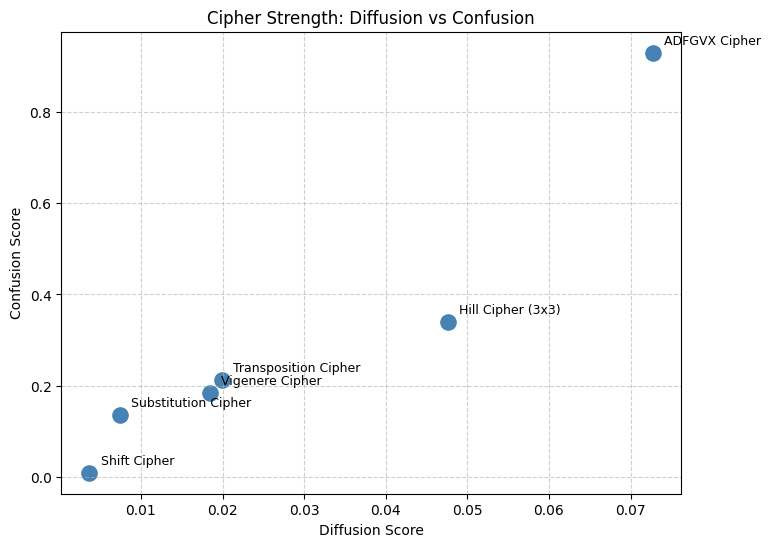

In [26]:
import matplotlib.pyplot as plt

# proportional offsets for labels
dx = (df["Diffusion"].max() - df["Diffusion"].min()) * 0.02
dy = (df["KICE (Confusion)"].max() - df["KICE (Confusion)"].min()) * 0.02

plt.figure(figsize=(8,6))
plt.scatter(df["Diffusion"], df["KICE (Confusion)"], s=120, c="steelblue")

for i, row in df.iterrows():
    plt.text(row["Diffusion"]+dx, row["KICE (Confusion)"]+dy, row["Cipher"], fontsize=9)

plt.xlabel("Diffusion Score")
plt.ylabel("Confusion Score")
plt.title("Cipher Strength: Diffusion vs Confusion")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

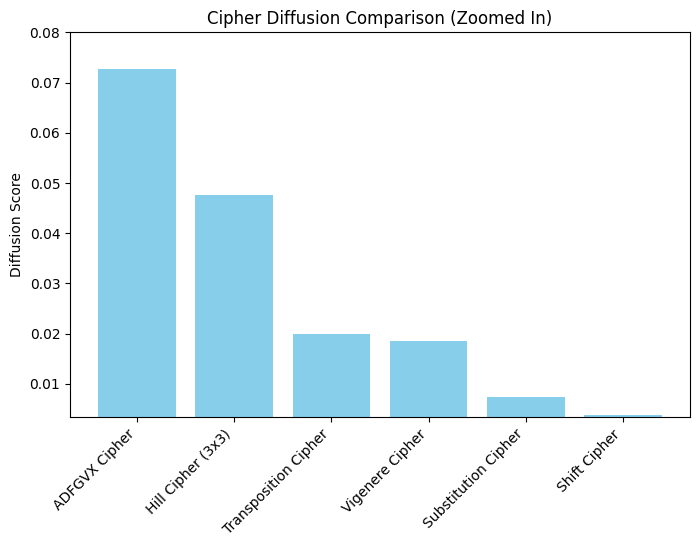

In [28]:
plt.figure(figsize=(8,5))
plt.bar(df["Cipher"], df["Diffusion"], color="skyblue")
plt.ylabel("Diffusion Score")
plt.title("Cipher Diffusion Comparison (Zoomed In)")
plt.xticks(rotation=45, ha="right")

# Zoom only to the diffusion range
ymin = df["Diffusion"].min() * 0.9
ymax = df["Diffusion"].max() * 1.1
plt.ylim(ymin, ymax)

plt.show()

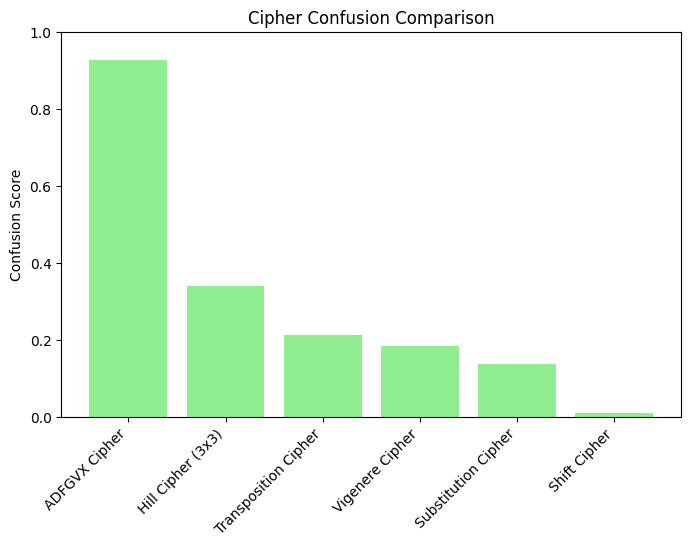

In [29]:
plt.figure(figsize=(8,5))
plt.bar(df["Cipher"], df["KICE (Confusion)"], color="lightgreen")
plt.ylabel("Confusion Score")
plt.title("Cipher Confusion Comparison")
plt.xticks(rotation=45, ha="right")
plt.ylim(0,1)   # normalize to 0–1 scale
plt.show()